In [1]:
import sys
# sys.path.append('../../')
import pandas as pd
from pathlib import Path
from itertools import compress
import os
import numpy as np
from os import listdir
from os.path import isfile, join,isdir
import matplotlib.pyplot  as plt
import cv2
import commons as cm
import mungling 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  scipy import stats 

In [2]:
figures_path='analysed/figures/'
beh=['approach']


In [3]:
# Load for all approaches that end in contact (Figure 6M)
raw_matrix_df=pd.read_csv('analysed/tables/analysed/approaches_end_contact_raw_day_2_thr_0.1.csv')

# Load for first approaches (Figure 6M)
# raw_matrix_df=pd.read_csv('analysed/tables/analysed/first_approach_raw_day_2_thr_0.4.csv')


raw_matrix_df['complex']=raw_matrix_df['complex'].str.replace("(",'').str.replace(")",'')
raw_matrix_df['complex']=raw_matrix_df['complex'].astype(complex)

thr=raw_matrix_df['behaviour_thr'].values[0]


C:\Users\arturoV\AppData\Local\Temp\ipykernel_38976\274901259.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  raw_matrix_df['complex']=raw_matrix_df['complex'].str.replace("(",'').str.replace(")",'')


In [4]:
def circular_mean_angle(complex_numbers:pd.Series):
    """Function to calculate circular mean from complex numbers

    Args:
        complex_numbers (pd.Series): complex_numbers, usually betwwen (pi,-pi) for more coherent stuff. I want 
        oposite angles to give an angle of 0. However absolute avlues of -45 or -135 are really strange.

    Returns:
        _type_: _description_
    """
    suma_com=np.sum(complex_numbers)
    final_angle=np.angle(suma_com,deg=False)


    return final_angle

def circular_magnitude(complex_numbers:pd.Series):
    """Function to calculate final magnitude from the sum of complex numbers

    Args:
        complex_numbers (pd.Series): angels in radians, usually betwwen (pi,-pi) for more coherent stuff. I want 
        oposite angles to give an angle of 0. However absolute avlues of -45 or -135 are really strange.

    Returns:
        _type_: _description_
    """
    suma_com=np.sum(complex_numbers)
    final_magnitude=np.abs(suma_com)/len(complex_numbers)


    return final_magnitude

def circular_variance(complex_numbers:pd.Series):
    """Function to calcalete circular variance from set of complex numbers

    Args:
        complex_numbers (pd.Series): _description_
    """
    magnitude=circular_magnitude(complex_numbers)
    return 1-magnitude


def boostrap_unpack(data:pd.Series):
    """Method to unpack bootstrap object values from pandas series

    Args:
        data (pd.Series): _description_

    Returns:
        _type_: _description_
    """

    low_conf=[row if isinstance(row,float) else np.round(row.confidence_interval[0],2) for row in data.values]
    high_conf=[row if isinstance(row,float) else np.round(row.confidence_interval[1],2) for row in data.values]
    boot_mean=[row if isinstance(row,float) else np.round(np.median(row.bootstrap_distribution),2) for row in data.values]
    boot_std=[row if isinstance(row,float) else np.round(row.standard_error,2) for row in data.values]

    return (boot_mean,boot_std,low_conf,high_conf)

## Lets take a look at the raw data

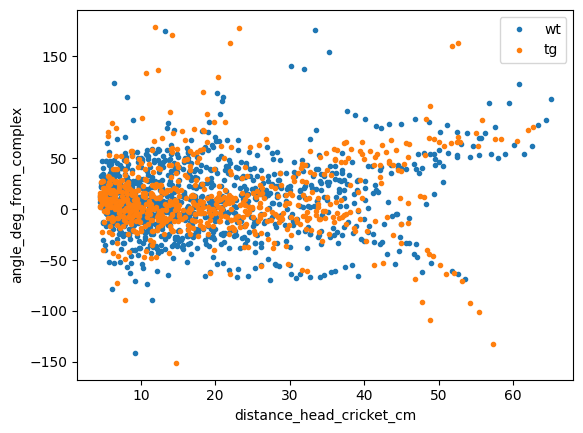

In [5]:
%matplotlib inline
data=raw_matrix_df
pheno='wt'
x='distance_head_cricket_cm'
y='angle_deg_from_complex'

data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')
x_control=data_aux[x].to_numpy()
y_control=data_aux[y].to_numpy()



plt.plot(x_control,y_control,'.')
pheno='tg'
data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')

x_mut=data_aux[x].to_numpy()
y_mut=data_aux[y].to_numpy()

plt.plot(x_mut,y_mut,'.')
plt.ylabel(y)
plt.xlabel(x)
plt.legend(['wt','tg'])

get only close ditances

C:\Users\arturoV\AppData\Local\Temp\ipykernel_38976\1598465571.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='angle_deg_from_complex', hue='phenotype', shade=True)


<Axes: xlabel='angle_deg_from_complex', ylabel='Density'>

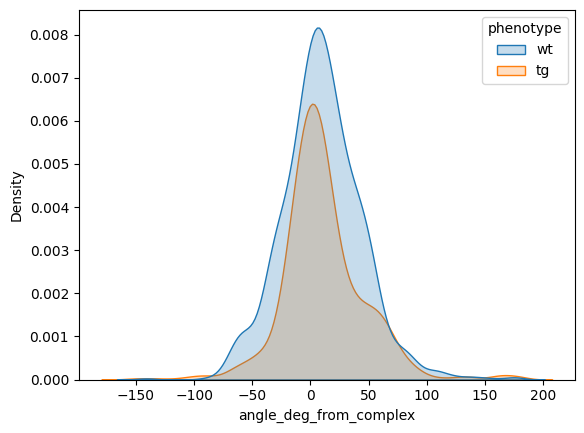

In [6]:
%matplotlib inline
data=raw_matrix_df.query("behaviour=='approach'")
data=data[['distance_head_cricket_cm','angle_deg_from_complex','phenotype']]

sns.kdeplot(data=data, x='angle_deg_from_complex', hue='phenotype', shade=True)
# sns.pairplot(data=data, hue="phenotype",kind='reg')

C:\Users\arturoV\AppData\Local\Temp\ipykernel_38976\2381328994.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='speed_cm_s', hue='phenotype', shade=True)


<Axes: xlabel='speed_cm_s', ylabel='Density'>

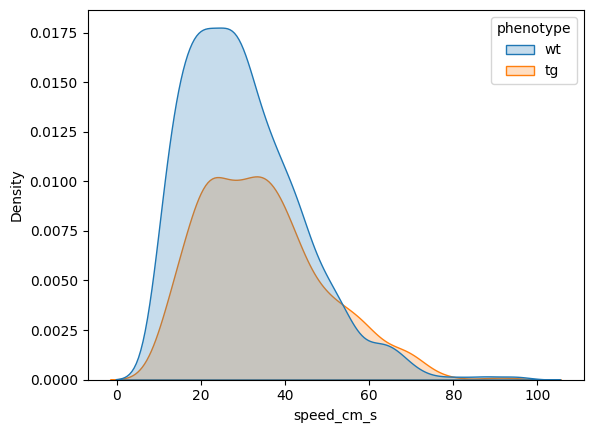

In [7]:
%matplotlib inline
data=raw_matrix_df.query("behaviour=='approach'")
data=data[['distance_head_cricket_cm','angle_deg_from_complex','speed_cm_s','phenotype']]

sns.kdeplot(data=data, x='speed_cm_s', hue='phenotype', shade=True)
# sns.pairplot(data=data, hue="phenotype",kind='reg')

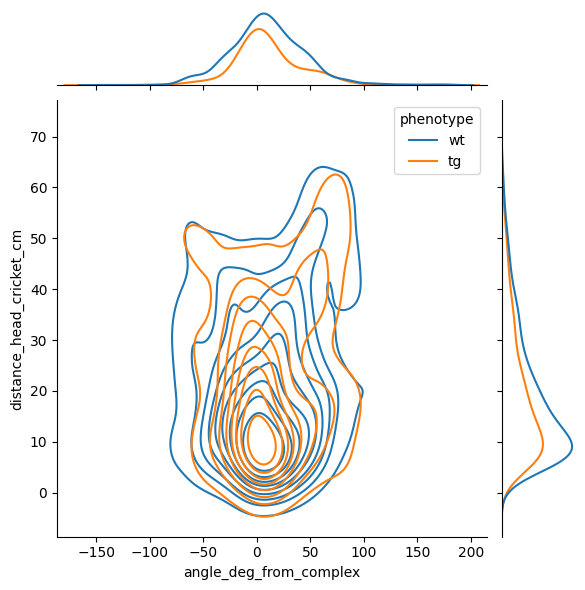

In [8]:
sns.jointplot(data=data, x='angle_deg_from_complex', y='distance_head_cricket_cm' ,hue='phenotype',kind='kde')


### Bining the signal
Lets bin the signal and extract a similar figure as in:  
Hoy et al. - 2016 - Vision Drives Accurate Approach Behavior during Pr.pdf


Lets take a look at the signal with the angles in absolute value

In [9]:
## Transform negative complex numbers to positive.
complex_angles=raw_matrix_df['complex'].to_numpy()
complex_angles.imag=complex_angles.imag*np.where(complex_angles.imag<0,-1,1)
raw_matrix_df['complex']=complex_angles
raw_matrix_df['angle_deg_from_complex']=np.angle(raw_matrix_df['complex'],deg=True)
raw_matrix_df['angle_rad_from_complex']=np.angle(raw_matrix_df['complex'],deg=False)



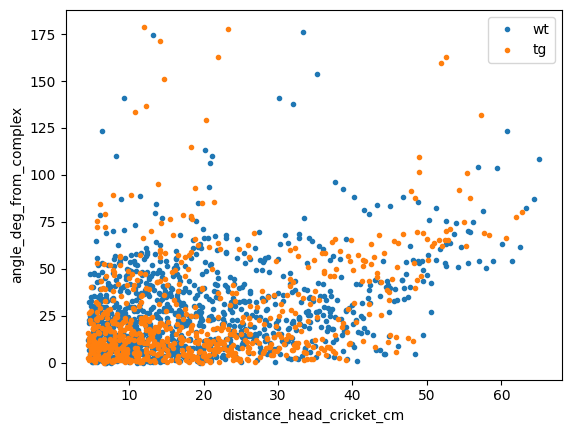

In [10]:
%matplotlib inline
data=raw_matrix_df
pheno='wt'
x='distance_head_cricket_cm'
y='angle_deg_from_complex'

data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')
x_control=data_aux[x].to_numpy()
y_control=data_aux[y].to_numpy()

plt.plot(x_control,y_control,'.')
pheno='tg'
data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')

x_mut=data_aux[x].to_numpy()
y_mut=data_aux[y].to_numpy()

plt.plot(x_mut,y_mut,'.')
plt.ylabel(y)
plt.xlabel(x)
plt.legend(['wt','tg'])

Now lets bin the signal and plot the angle mean of angles in absolute value

Falta por probar:
1) Probar con media angular de valores absolutos
2) plot de bootstrap con CI
3) p valor bootstrap

Doing the circular mean of angles

In [11]:
interval=14
from scipy.stats import sem
from scipy.stats import bootstrap

interval_1=np.linspace(4,40,interval)



range_grouping=(raw_matrix_df.query("behaviour==@beh").
                groupby(['phenotype','behaviour',
                        pd.cut(raw_matrix_df['distance_head_cricket_cm'], interval_1)
                         ])
                   .agg(diff_time=('diff_time',np.sum),
                     time_0=('time',np.min),
                     time_end=('time',np.max),
                     max_speed=('speed_cm_s',np.max),
                     min_speed=('speed_cm_s',np.min),
                     mean_speed=('speed_cm_s',np.mean),
                     max_behaviour_dist=('distance_head_cricket_cm',np.max),
                     min_behaviour_dist=('distance_head_cricket_cm',np.min),
                     first_beh_distance=('distance_head_cricket_cm',lambda x: x.iloc[0]),
                    #  mean_angle=('complex',lambda x: np.rad2deg(circular_mean_angle(x))),
                     mean_angle=('complex',lambda x:circular_mean_angle(x)),
                     magnitude=('complex',circular_magnitude),
                     mean_dist_head_cricket_cm=('distance_head_cricket_cm',np.mean),
                     distance_std=('distance_head_cricket_cm',np.std),
                     circular_variance=('complex',circular_variance),
                     angle_sem=('angle_deg_from_complex',sem),
                     std_boot=('complex',lambda x: np.std(bootstrap((x,),circular_mean_angle, confidence_level=0.95).bootstrap_distribution)),
                     angle_boot=('complex',lambda x: bootstrap((x,),circular_mean_angle, confidence_level=0.95)),
                     counts=('diff_time',len))).reset_index()

range_grouping


# max_counts_tg=np.max(range_grouping.query("phenotype=='tg'")).counts
# max_counts_wt=np.max(range_grouping.query("phenotype=='wt'")).counts

tot_counts_tg=np.sum(range_grouping.query("phenotype=='tg'")).counts
tot_counts_wt=np.sum(range_grouping.query("phenotype=='wt'")).counts

range_grouping.loc[range_grouping['phenotype']=='tg',['counts']]=range_grouping.loc[range_grouping['phenotype']=='tg',['counts']]/tot_counts_tg
range_grouping.loc[range_grouping['phenotype']=='wt',['counts']]=range_grouping.loc[range_grouping['phenotype']=='wt',['counts']]/tot_counts_wt

c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return reduction(axis=axis, out=out, **passkwargs)


In [12]:
boot_mean,boot_std,low_conf,high_conf=boostrap_unpack(range_grouping['angle_boot'])
range_grouping['boot_mean']=boot_mean
range_grouping['boot_std']=boot_std
range_grouping['low_conf']=low_conf
range_grouping['high_conf']=high_conf

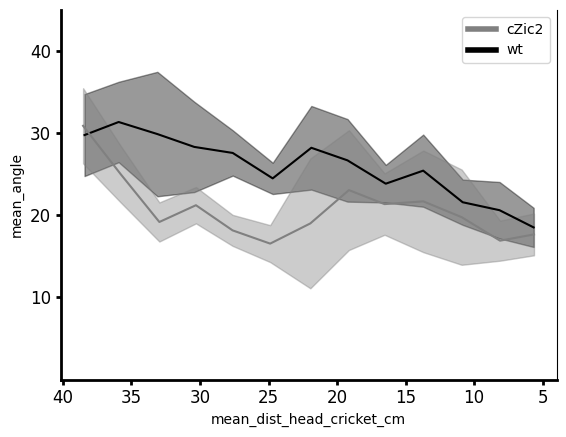

In [13]:
%matplotlib inline
from matplotlib.lines import Line2D

# y_tick_labels_radians =np.arange(0,np.pi/3,np.pi/10)
legend_lines = [Line2D([0], [0], color='gray', lw=4),
                Line2D([0], [0], color='black', lw=4),]
a=0.174533 # 10 degrees in redians for plot

y_lim=(0,np.pi/4)
data=range_grouping
pheno='wt'
x='mean_dist_head_cricket_cm'
y='mean_angle'

error='circular_variance'


boot_err='std_boot'
boot_low='low_conf'
boot_high='high_conf'


error_type='circular_variance'

fig,ax=plt.subplots(1,)
data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')
x_control=data_aux[x].values
y_control=data_aux[y].values
control_err=data_aux[error].values
control_boot=data_aux[boot_err].values
control_boot_low=data_aux[boot_low].values
control_boot_high=data_aux[boot_high].values

plt.plot(x_control,y_control,'-',color='black')

if error_type=='circular_variance':
   # plt.errorbar(x_control,y_control,control_err,color='gray')
   ax.fill_between(x_control,y_control-control_err,y_control+control_err,color='black',alpha=0.4)

if error_type=='std_boot':
   # plt.errorbar(x_control,y_control,control_boot,color='gray')
    ax.fill_between(x_control,y_control-control_boot,y_control+control_boot,color='black',alpha=0.4)

if error_type=='conf_int':
    ax.fill_between(x_control,control_boot_low,control_boot_high,color='black',alpha=0.4,fmt='none')


pheno='tg'
data_aux=data.query('phenotype==@pheno & \
                               behaviour==@beh')
x_mut=data_aux[x].values
y_mut=data_aux[y].values
mut_err=data_aux[error].values
mut_boot=data_aux[boot_err].values
mut_boot_low=data_aux[boot_low].values
mut_boot_high=data_aux[boot_high].values
plt.plot(x_mut,y_mut,'-',color='gray')

if error_type=='circular_variance':
   # plt.errorbar(x_mut,y_mut,mut_err,color='black')
    ax.fill_between(x_mut,y_mut-mut_err,y_mut+mut_err,color='gray',alpha=0.4)

if error_type=='std_boot':
   # plt.errorbar(x_mut,y_mut,mut_boot,color='black')
    ax.fill_between(x_mut,y_mut-mut_boot,y_mut+mut_boot,color='gray',alpha=0.4)

if error_type=='conf_int':
    ax.fill_between(x_mut,mut_boot_low,mut_boot_high,color='gray',alpha=0.4,fmt='none')


plt.ylabel(y)
plt.xlabel(x)
plt.gca().invert_xaxis()
plt.ylim(*y_lim)

ax.yaxis.set_ticks([a,a*2,a*3,a*4])

y_tick_labels_radians =ax.get_yticklabels()
y_tick_labels_degrees = [f'{np.rad2deg(float(label.get_text())):.0f}' for label in y_tick_labels_radians]
ax.set_yticklabels(y_tick_labels_degrees)


ax.legend(legend_lines, ['cZic2', 'wt'])
ax.tick_params(axis='x', labelsize=12,direction='out',width=2)
ax.tick_params(axis='y', labelsize=12,direction='out',width=2)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)  # Bottom axis line
ax.spines['left'].set_linewidth(2)    # Left axis line
# fig.set_figheight(6)
# fig.set_figwidth(5)

fig.savefig(figures_path+f'orientation_distance_{thr}.tiff', bbox_inches='tight', dpi=300, format='tiff')


Exmaple of mean angle bootstrap distribution

Text(0.5, 1.0, 'mean=0.4-+0.07 (0.29,0.56) sem:0.0')

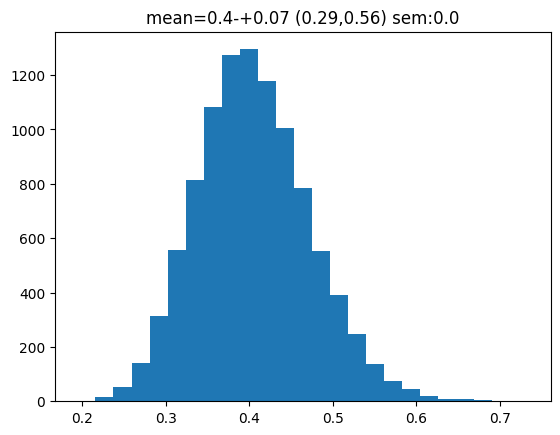

In [14]:

boot=range_grouping['angle_boot'].iloc[5]
fig, ax = plt.subplots()
boot_mean=np.round(np.median(boot.bootstrap_distribution),2)
boot_std=np.round(np.median(boot.standard_error),2)
low_conf=np.round(boot.confidence_interval[0],2)
high_conf=np.round(boot.confidence_interval[1],2)
boot_sem=np.round(sem(boot.bootstrap_distribution),2)

ax.hist(boot.bootstrap_distribution, bins=25)
plt.title(f'mean={boot_mean}-+{boot_std} ({low_conf},{high_conf}) sem:{boot_sem}')
